## Trực quan dữ liệu Covid 19

### Data range analysis

In [8]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

RAW_DATA_PATH = r"../data/raw"
PROCESSED_DATA_PATH = r"../data/processed/daily_data"

In [9]:
daily_files = [
    'daily_confirmed_cases.csv',
    'daily_deaths_cases.csv',
    'daily_recovered_cases.csv'
]

In [10]:
daily_data = {}
for file in daily_files:
    df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, file))
    key = file.replace("daily_", "").replace("_cases.csv", "")
    daily_data[key] = df
    print(f"{key}: {df.shape}")

confirmed: (193, 497)
deaths: (193, 497)
recovered: (193, 497)


In [11]:
confirmed_df = daily_data.get("confirmed")
deaths_df = daily_data.get("deaths")
recovered_df = daily_data.get("recovered")

In [13]:
def reshape_daily_wide_file(df, value_name):
    df_long = df.melt(
        id_vars=['Country/Region', 'Lat', 'Long'],
        var_name='ObservationDate',
        value_name=value_name
    )
    df_long['ObservationDate'] = pd.to_datetime(df_long['ObservationDate'], format="%m/%d/%y", errors='coerce')
    return df_long

confirmed_long = reshape_daily_wide_file(confirmed_df, "Confirmed")
deaths_long = reshape_daily_wide_file(deaths_df, "Deaths")
recovered_long = reshape_daily_wide_file(recovered_df, "Recovered")

# === Gộp 3 dataframe lại ===
covid_data = confirmed_long.merge(deaths_long, on=['Country/Region', 'Lat', 'Long', 'ObservationDate'], how='outer')
covid_data = covid_data.merge(recovered_long, on=['Country/Region', 'Lat', 'Long', 'ObservationDate'], how='outer')

In [14]:
# Convert ObservationDate to datetime
covid_data['ObservationDate'] = pd.to_datetime(covid_data['ObservationDate'], errors='coerce')

# Calculate the date range
start_date = covid_data['ObservationDate'].min()
end_date = covid_data['ObservationDate'].max()

print(f"Date Range: {start_date.date()} to {end_date.date()}")


Date Range: 2020-01-22 to 2021-05-29


## Phân tích xu hướng của dữ liệu

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_trend_analysis(df, country=None):
    sns.set(style="whitegrid")

    # Đảm bảo cột ObservationDate là datetime
    df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

    # Lọc theo quốc gia nếu được cung cấp
    if country:
        df = df[df['Country/Region'] == country]

    # Gom nhóm theo ngày
    daily = df.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

    # Tính trung bình trượt 7 ngày
    daily['Confirmed_MA'] = daily['Confirmed'].rolling(window=7).mean()
    daily['Deaths_MA'] = daily['Deaths'].rolling(window=7).mean()
    daily['Recovered_MA'] = daily['Recovered'].rolling(window=7).mean()

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))

    # Confirmed trend
    plt.subplot(3, 1, 1)
    sns.lineplot(data=daily, x='ObservationDate', y='Confirmed_MA', color='blue')
    plt.title(f'Xu hướng số ca nhiễm được xác nhận{" tại " + country if country else ""}')
    plt.ylabel('Số ca nhiễm (7-day MA)')
    plt.xlabel('Ngày')

    # Deaths trend
    plt.subplot(3, 1, 2)
    sns.lineplot(data=daily, x='ObservationDate', y='Deaths_MA', color='red')
    plt.title(f'Xu hướng số ca tử vong{" tại " + country if country else ""}')
    plt.ylabel('Số ca tử vong (7-day MA)')
    plt.xlabel('Ngày')

    # Recovered trend
    plt.subplot(3, 1, 3)
    sns.lineplot(data=daily, x='ObservationDate', y='Recovered_MA', color='green')
    plt.title(f'Xu hướng số ca hồi phục{" tại " + country if country else ""}')
    plt.ylabel('Số ca hồi phục (7-day MA)')
    plt.xlabel('Ngày')

    plt.tight_layout()
    plt.show()


In [26]:
def plot_comparison_trend(df, countries):
    sns.set(style="whitegrid")
    df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

    plt.figure(figsize=(14, 6))

    for country in countries:
        country_df = df[df['Country/Region'] == country]
        daily = country_df.groupby('ObservationDate')['Confirmed'].sum().rolling(window=7).mean().reset_index()
        sns.lineplot(data=daily, x='ObservationDate', y='Confirmed', label=country)

    plt.title("So sánh xu hướng số ca nhiễm giữa các quốc gia")
    plt.xlabel("Ngày")
    plt.ylabel("Số ca nhiễm (7-day MA)")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Xu hướng toàn cầu (gộp tất cả quốc gia) theo từng tuần

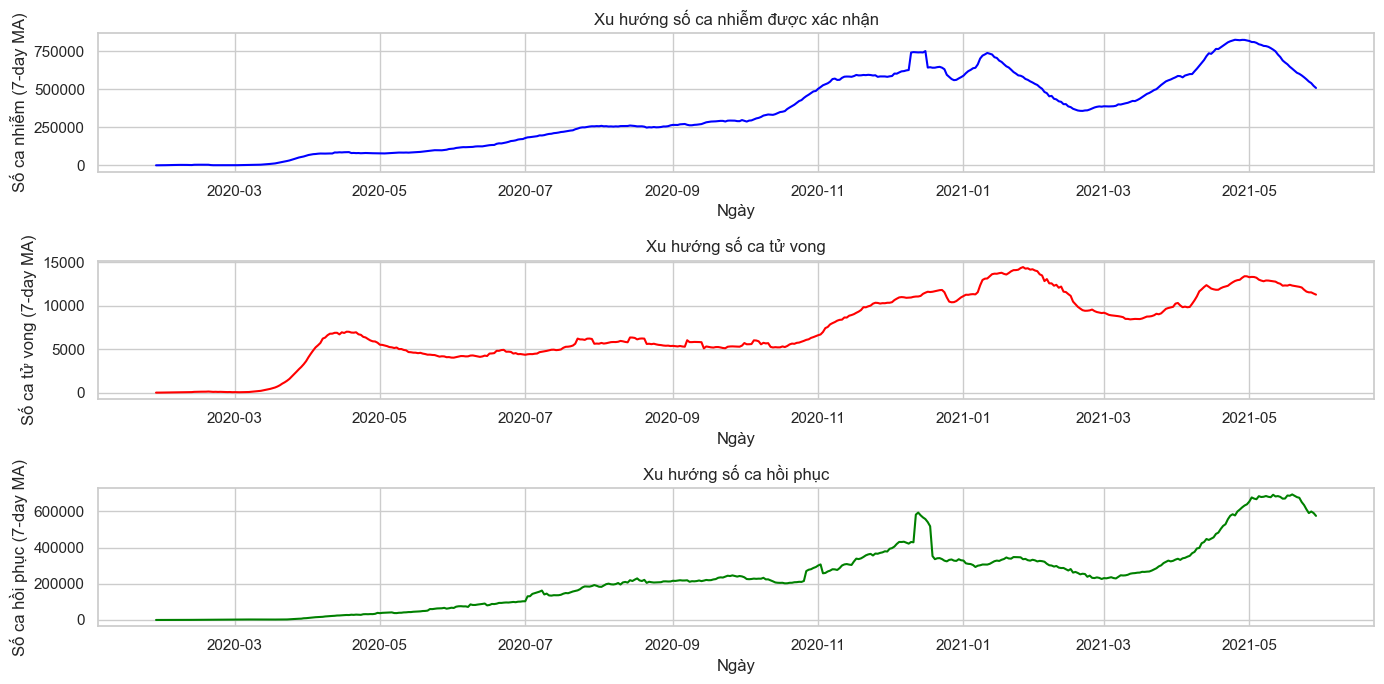

In [27]:
plot_trend_analysis(covid_data)

### Phân tích xu hướng cho một số quốc gia cụ thể

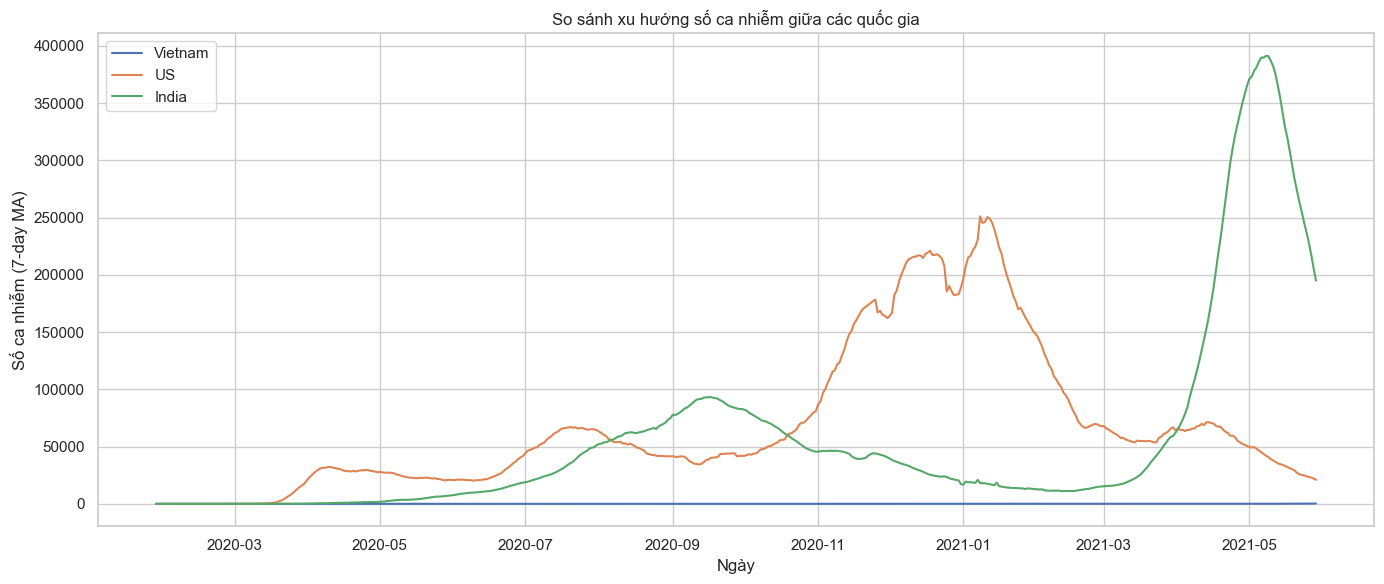

In [34]:
plot_comparison_trend(covid_data, countries=["Vietnam","US","India"])


### Phân tích xu hướng của trường hợp đặc biệt là Trung Quốc

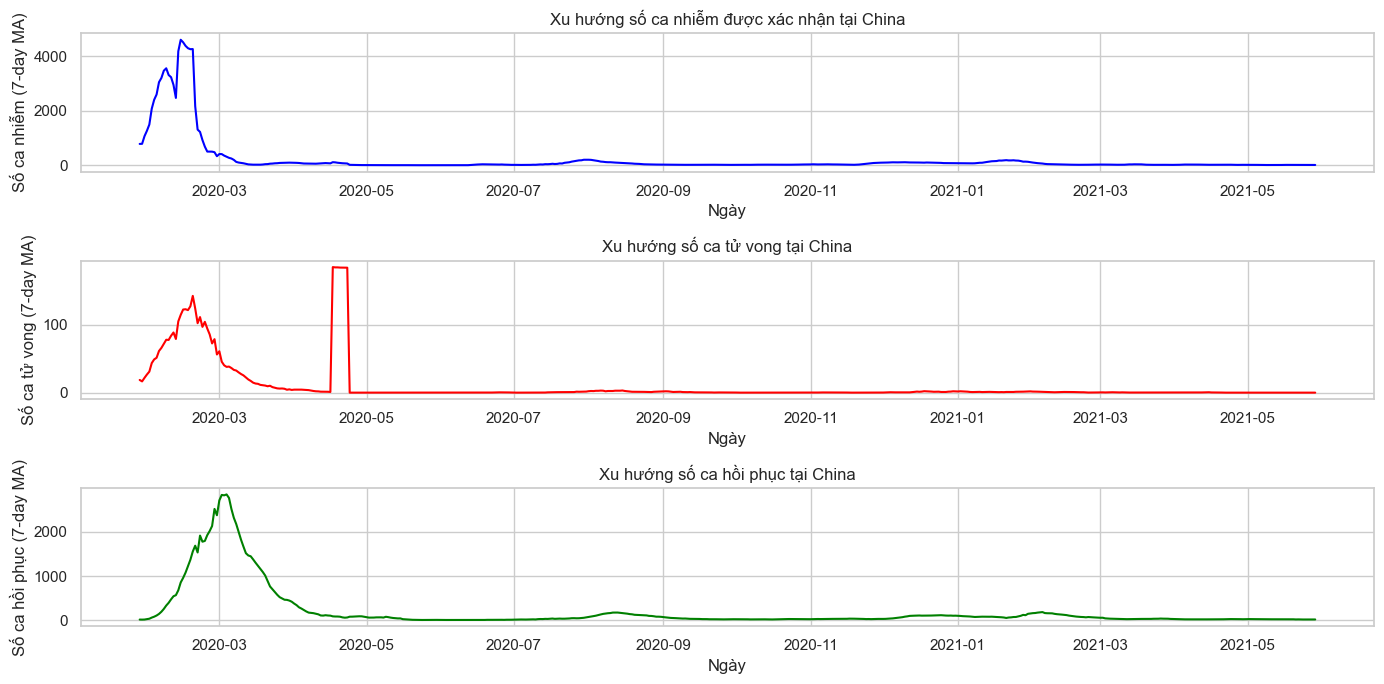

In [31]:
plot_trend_analysis(covid_data, country="China")

### Tính tăng trưởng hàng ngày và hàng tuần cho toàn thế giới (có thể lọc theo quốc gia sau nếu muốn)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử bạn đã có: covid_data (dữ liệu gốc)
df_full_grouped = covid_data.copy()

# Đảm bảo cột ngày đúng kiểu
df_full_grouped['ObservationDate'] = pd.to_datetime(df_full_grouped['ObservationDate'])

# Gom nhóm theo ngày (toàn cầu hoặc quốc gia tùy chọn)
df_full_grouped = df_full_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths']].sum().reset_index()

# Tính tăng trưởng hằng ngày (daily growth rate %)
df_full_grouped['Tốc độ gia tăng của số ca nhiễm hắng ngày'] = df_full_grouped['Confirmed'].pct_change().fillna(0) * 100
df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng ngày'] = df_full_grouped['Deaths'].pct_change().fillna(0) * 100

# Tăng trưởng hằng tuần (so với 7 ngày trước)
df_full_grouped['Tốc độ gia tăng của số ca nhiễm hằng tuần'] = df_full_grouped['Confirmed'].pct_change(periods=7).fillna(0) * 100
df_full_grouped['Tốc độ gia tăng của số ca tử vong hằng tuần'] = df_full_grouped['Deaths'].pct_change(periods=7).fillna(0) * 100

# Xem dữ liệu
df_full_grouped.head(50)[['ObservationDate', 'Confirmed', 'Deaths',
                          'Tốc độ gia tăng của số ca nhiễm hắng ngày', 'Tốc độ gia tăng của số ca tử vong hằng ngày',
                          'Tốc độ gia tăng của số ca nhiễm hằng tuần', 'Tốc độ gia tăng của số ca tử vong hằng tuần']]


,ObservationDate,Confirmed,Deaths,Tốc độ gia tăng của số ca nhiễm hắng ngày,Tốc độ gia tăng của số ca tử vong hằng ngày,Tốc độ gia tăng của số ca nhiễm hằng tuần,Tốc độ gia tăng của số ca tử vong hằng tuần
0,2020-01-22,557.0,17.0,0.000000,0.000000,0.000000,0.000000
1,2020-01-23,98.0,1.0,-82.405745,-94.117647,0.000000,0.000000
2,2020-01-24,286.0,8.0,191.836735,700.000000,0.000000,0.000000
3,2020-01-25,492.0,16.0,72.027972,100.000000,0.000000,0.000000
4,2020-01-26,685.0,14.0,39.227642,-12.500000,0.000000,0.000000
5,2020-01-27,809.0,26.0,18.102190,85.714286,0.000000,0.000000
6,2020-01-28,2651.0,49.0,227.688504,88.461538,0.000000,0.000000
7,2020-01-29,589.0,2.0,-77.781969,-95.918367,5.745063,-88.235294
8,2020-01-30,2068.0,38.0,251.103565,1800.000000,2010.204082,3700.000000
9,2020-01-31,1692.0,42.0,-18.181818,10.526316,491.608392,425.000000


### Top 10 quốc gia có nhiều ca nhiễm, tử vong, hồi phục

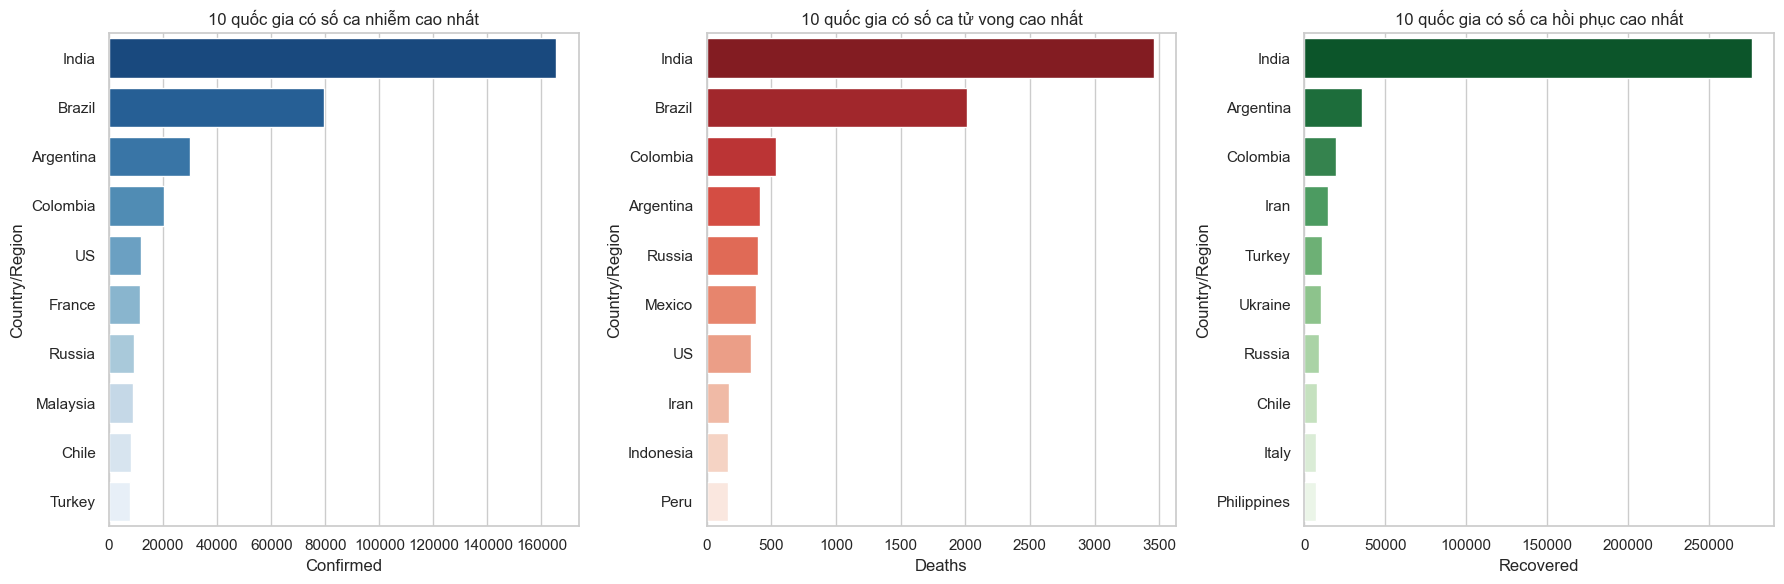

In [39]:
# Lấy dữ liệu mới nhất theo từng quốc gia
df_country_wise_latest = covid_data.copy()
latest_date = df_country_wise_latest['ObservationDate'].max()

# Lọc data mới nhất
df_country_wise_latest = df_country_wise_latest[df_country_wise_latest['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Top 10 quốc gia theo từng chỉ số
top_countries_cases = df_country_wise_latest.nlargest(10, 'Confirmed')[['Country/Region', 'Confirmed']]
top_countries_deaths = df_country_wise_latest.nlargest(10, 'Deaths')[['Country/Region', 'Deaths']]
top_countries_recovered = df_country_wise_latest.nlargest(10, 'Recovered')[['Country/Region', 'Recovered']]

# Vẽ biểu đồ bar
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Confirmed cases
sns.barplot(x='Confirmed', y='Country/Region',
            data=top_countries_cases, ax=axes[0],
            palette='Blues_r', hue='Country/Region', legend=False)
axes[0].set_title('10 quốc gia có số ca nhiễm cao nhất')
# Deaths
sns.barplot(x='Deaths', y='Country/Region',
            data=top_countries_deaths, ax=axes[1],
            palette='Reds_r', hue='Country/Region', legend=False)
axes[1].set_title("10 quốc gia có số ca tử vong cao nhất")

# Recovered
sns.barplot(x='Recovered', y='Country/Region',
            data=top_countries_recovered, ax=axes[2],
            palette='Greens_r', hue='Country/Region', legend=False)
axes[2].set_title('10 quốc gia có số ca hồi phục cao nhất')

plt.tight_layout()
plt.show()


### Tính tỷ lệ tử vong và hồi phục

In [40]:
df_country_wise_latest["Tỉ lệ tử vong (%)"] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest["Tỉ lệ hồi phục (%)"] = (df_country_wise_latest['Recovered'] / df_country_wise_latest['Confirmed']) * 100

# Hiển thị kết quả
df_country_wise_latest[['Country/Region', 'Confirmed', 'Deaths', 'Recovered',
                        'Tỉ lệ tử vong (%)', 'Tỉ lệ hồi phục (%)']].head(10)


,Country/Region,Confirmed,Deaths,Recovered,Tỉ lệ tử vong (%),Tỉ lệ hồi phục (%)
0,Afghanistan,981.0,18.0,162.0,1.834862,16.513761
1,Albania,12.0,1.0,118.0,8.333333,983.333333
2,Algeria,258.0,5.0,187.0,1.937984,72.480620
3,Andorra,0.0,0.0,0.0,NaN,NaN
4,Angola,236.0,8.0,69.0,3.389831,29.237288
5,Antigua and Barbuda,0.0,0.0,0.0,NaN,NaN
6,Argentina,29841.0,415.0,35624.0,1.390704,119.379377
7,Armenia,42.0,5.0,186.0,11.904762,442.857143
8,Australia,13.0,0.0,4.0,0.000000,30.769231
9,Austria,498.0,4.0,857.0,0.803213,172.088353


### Phân tích và so sánh xu hướng theo tháng và tuần

In [41]:
df_full_grouped = covid_data.copy()
df_full_grouped['ObservationDate'] = pd.to_datetime(df_full_grouped['ObservationDate'])

# Gom nhóm toàn cầu theo ngày
df_full_grouped = df_full_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Thêm cột Month, Week
df_full_grouped['Month'] = df_full_grouped['ObservationDate'].dt.month
df_full_grouped['Week'] = df_full_grouped['ObservationDate'].dt.isocalendar().week

# Gom nhóm theo tháng
monthly_data = df_full_grouped.groupby('Month')[['Confirmed', 'Deaths', 'Recovered']].mean()

# Gom nhóm theo tuần
weekly_data = df_full_grouped.groupby('Week')[['Confirmed', 'Deaths', 'Recovered']].mean()


### Vẽ biểu đồ tháng và tuần

<Figure size 1400x600 with 0 Axes>

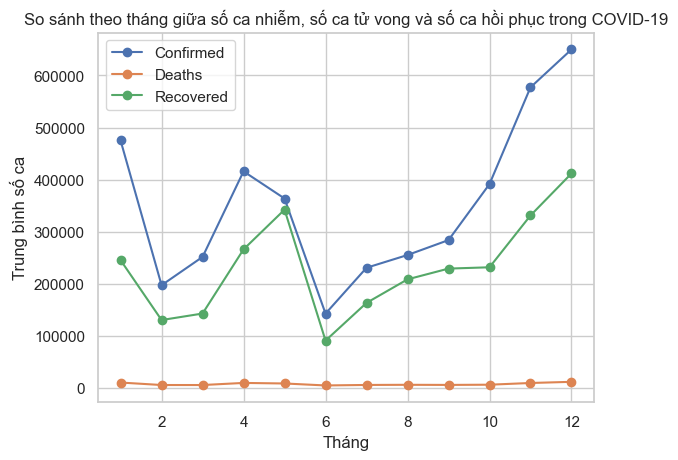

<Figure size 1400x600 with 0 Axes>

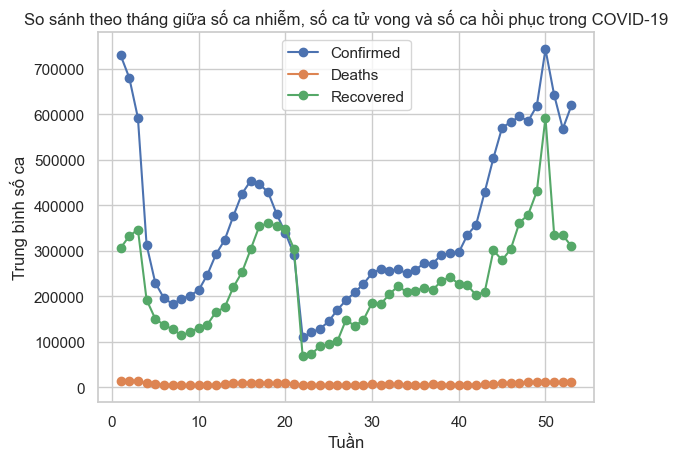

In [42]:
# Biểu đồ theo tháng
plt.figure(figsize=(14,6))
monthly_data.plot(kind='line', marker='o')
plt.title('So sánh theo tháng giữa số ca nhiễm, số ca tử vong và số ca hồi phục trong COVID-19')
plt.xlabel('Tháng')
plt.ylabel('Trung bình số ca')
plt.grid(True)
plt.show()

# Biểu đồ theo tuần
plt.figure(figsize=(14,6))
weekly_data.plot(kind='line', marker='o')
plt.title('So sánh theo tháng giữa số ca nhiễm, số ca tử vong và số ca hồi phục trong COVID-19')
plt.xlabel('Tuần')
plt.ylabel('Trung bình số ca')
plt.grid(True)
plt.show()


### Vẽ biểu đồ số ca nhiễm theo thời gian cho top 10 quốc gia

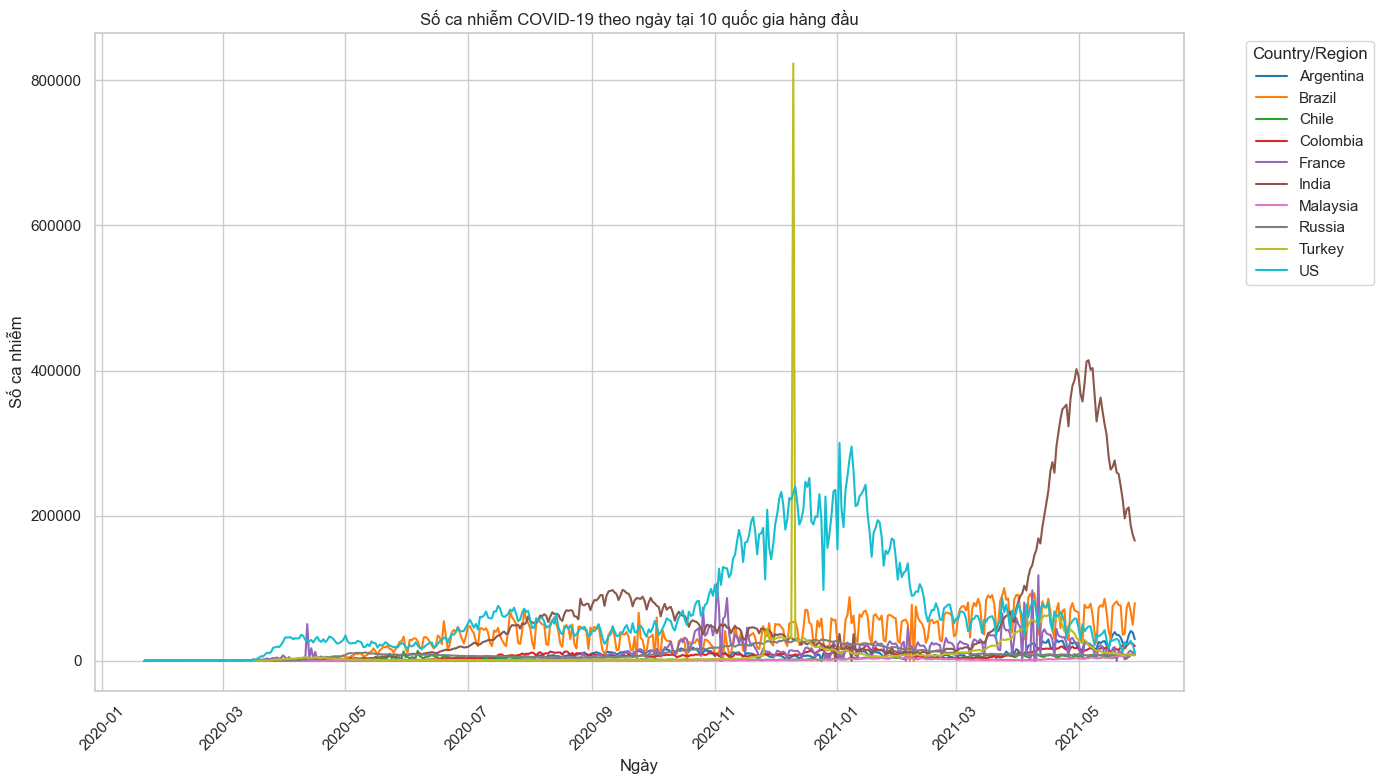

In [46]:
# Chuẩn bị dữ liệu country_wise mới nhất
latest_date = covid_data['ObservationDate'].max()
df_country_wise_latest = covid_data[covid_data['ObservationDate'] == latest_date]
df_country_wise_latest = df_country_wise_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Lấy top 10 quốc gia
top_10_countries_list = df_country_wise_latest.nlargest(10, 'Confirmed')['Country/Region'].tolist()

# Lọc dữ liệu theo các quốc gia này
df_top10 = covid_data[covid_data['Country/Region'].isin(top_10_countries_list)]

# Gom nhóm theo ngày và quốc gia
df_top10_grouped = df_top10.groupby(['ObservationDate', 'Country/Region'])[['Confirmed']].sum().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14,8))
sns.lineplot(x='ObservationDate', y='Confirmed', hue='Country/Region', data=df_top10_grouped, palette='tab10')
plt.title('Số ca nhiễm COVID-19 theo ngày tại 10 quốc gia hàng đầu')
plt.xlabel('Ngày')
plt.ylabel('Số ca nhiễm')
plt.legend(title='Country/Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Tính và vẽ daily new cases/deaths/recoveries cho một quốc gia

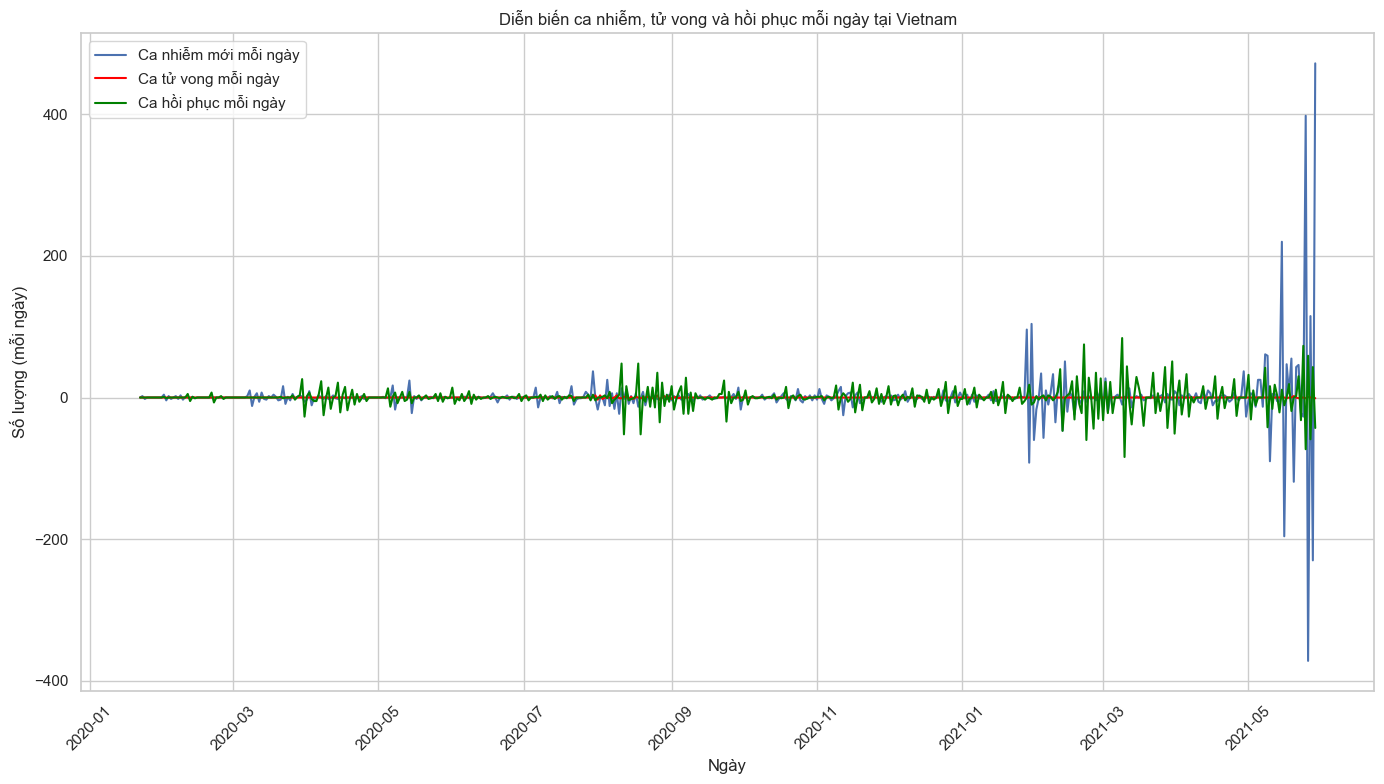

In [51]:
# Bản sao dữ liệu và chuẩn hóa thời gian
df_daily = covid_data.copy()
df_daily['ObservationDate'] = pd.to_datetime(df_daily['ObservationDate'])

# Gom nhóm theo quốc gia và ngày (tránh trùng lặp tỉnh/thành)
df_daily = df_daily.groupby(['Country/Region', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
df_daily = df_daily.sort_values(['Country/Region', 'ObservationDate'])

# Tính số ca mới mỗi ngày (dạng diff bình thường)
df_daily['Daily New Cases'] = df_daily.groupby('Country/Region')['Confirmed'].diff().fillna(0)
df_daily['Daily New Deaths'] = df_daily.groupby('Country/Region')['Deaths'].diff().fillna(0)
df_daily['Daily New Recoveries'] = df_daily.groupby('Country/Region')['Recovered'].diff().fillna(0)

# Chọn quốc gia cần vẽ
country_name = 'Vietnam'
sample_country = df_daily[df_daily['Country/Region'] == country_name]

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
sns.lineplot(x='ObservationDate', y='Daily New Cases', data=sample_country, label='Ca nhiễm mới mỗi ngày')
sns.lineplot(x='ObservationDate', y='Daily New Deaths', data=sample_country, label='Ca tử vong mỗi ngày', color='red')
sns.lineplot(x='ObservationDate', y='Daily New Recoveries', data=sample_country, label='Ca hồi phục mỗi ngày', color='green')

plt.title(f'Diễn biến ca nhiễm, tử vong và hồi phục mỗi ngày tại {country_name}')
plt.xlabel('Ngày')
plt.ylabel('Số lượng (mỗi ngày)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tỷ lệ tử vong trên tổng số ca nhiễm đã xác nhận

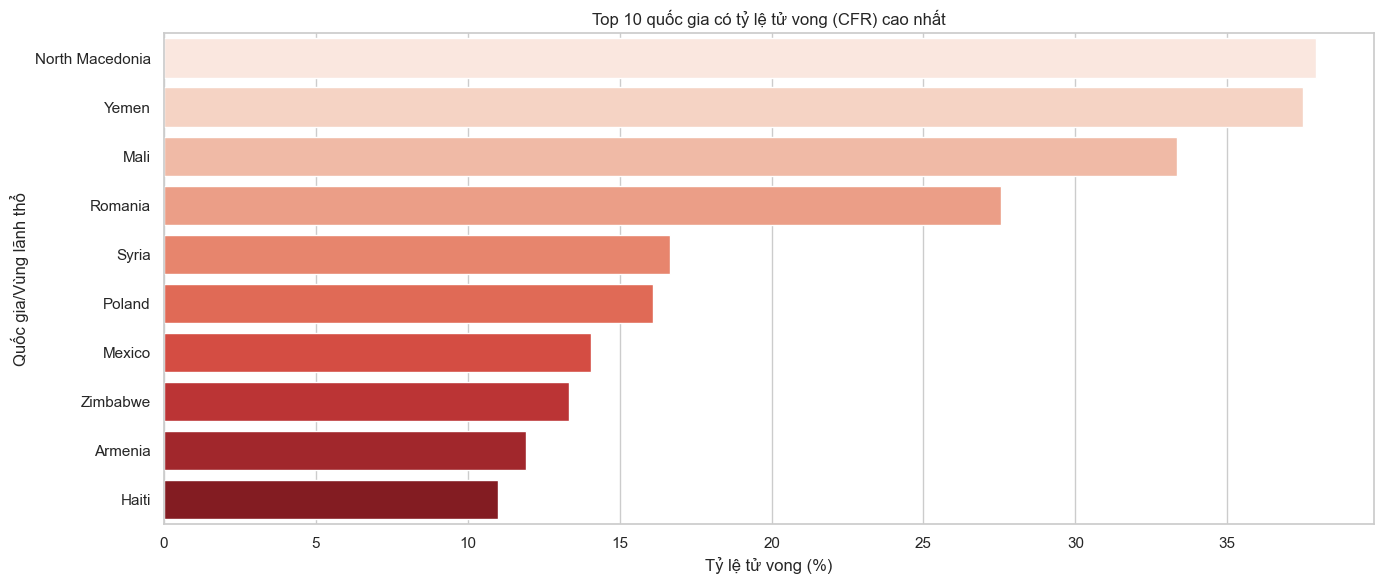

In [53]:
# Tính tỷ lệ tử vong (CFR)
df_country_wise_latest['CFR (%)'] = (df_country_wise_latest['Deaths'] / df_country_wise_latest['Confirmed']) * 100
df_country_wise_latest = df_country_wise_latest.replace([np.inf, -np.inf], np.nan).dropna(subset=['CFR (%)'])

# Top 10 quốc gia có tỷ lệ tử vong cao nhất
top_10_cfr = df_country_wise_latest.nlargest(10, 'CFR (%)')

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
sns.barplot(
    x='CFR (%)',
    y='Country/Region',
    data=top_10_cfr,
    palette='Reds',
    hue='Country/Region',
    legend=False
)

plt.title('Top 10 quốc gia có tỷ lệ tử vong (CFR) cao nhất')
plt.xlabel('Tỷ lệ tử vong (%)')
plt.ylabel('Quốc gia/Vùng lãnh thổ')
plt.tight_layout()
plt.show()

### Số ca đang điều trị so với số ca đã hồi phục cho 1 quốc gia (ví dụ: India)

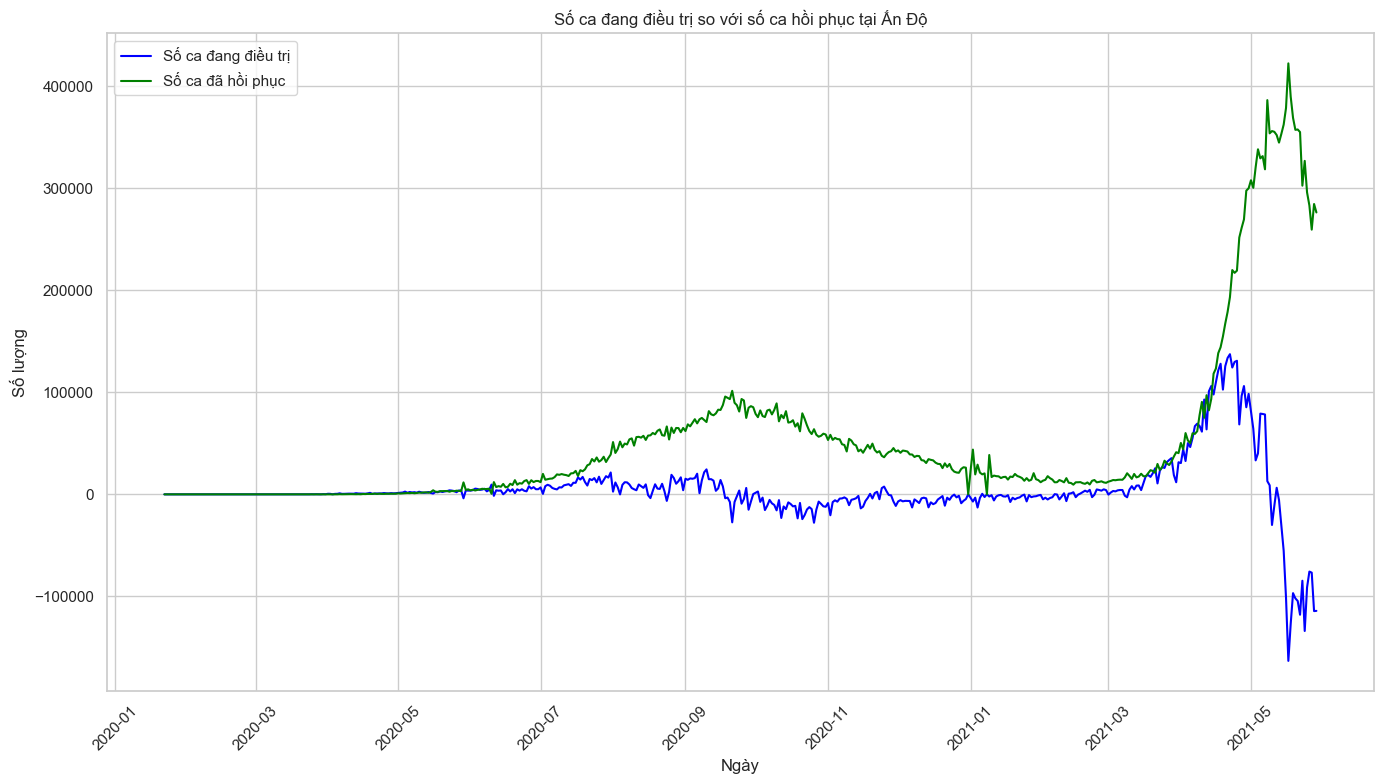

In [59]:
df_india = covid_data[covid_data['Country/Region'] == 'India'].copy()
df_india = df_india.groupby('ObservationDate')[['Confirmed', 'Recovered', 'Deaths']].sum().reset_index()

# Tính Active
df_india['Active'] = df_india['Confirmed'] - df_india['Recovered'] - df_india['Deaths']

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
sns.lineplot(x='ObservationDate', y='Active', data=df_india, label='Số ca đang điều trị', color='blue')
sns.lineplot(x='ObservationDate', y='Recovered', data=df_india, label='Số ca đã hồi phục', color='green')
plt.title('Số ca đang điều trị so với số ca hồi phục tại Ấn Độ')
plt.xlabel('Ngày')
plt.ylabel('Số lượng')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Xử lý dữ liệu theo châu lục

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
import numpy as np
from scipy.stats import pearsonr
# Bước 1: Lấy ngày mới nhất trong dữ liệu
latest_date = covid_data['ObservationDate'].max()

# Bước 2: Lọc dữ liệu ngày mới nhất
df_latest = covid_data[covid_data['ObservationDate'] == latest_date].copy()

# Bước 3: Gom nhóm theo quốc gia
df_latest_grouped = df_latest.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Bước 4: Tính số ca đang nhiễm (Active = Confirmed - Deaths - Recovered)
df_latest_grouped['Active'] = df_latest_grouped['Confirmed'] - df_latest_grouped['Deaths'] - df_latest_grouped['Recovered']

cc = coco.CountryConverter()

df_latest_grouped['Continent'] = cc.convert(names=df_latest_grouped['Country/Region'], to='continent')




Diamond Princess not found in regex
MS Zaandam not found in regex


In [81]:
mask_negative = df_latest_grouped['Active'] < 0
print(df_latest_grouped[mask_negative][['ObservationDate','Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active']])


KeyError: "['ObservationDate'] not in index"

In [ ]:
countries_with_negative_active = df_latest_grouped[mask_negative]['Country/Region'].tolist()
df_suspect_rows = covid_data[
    (covid_data['ObservationDate'] == latest_date) &
    (covid_data['Country/Region'].isin(countries_with_negative_active))
]
print(df_suspect_rows[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']])


           Country/Region  Confirmed  Deaths  Recovered
987               Albania       12.0     1.0      118.0
3457            Argentina    29841.0   415.0    35624.0
3951              Armenia       42.0     5.0      186.0
4939              Austria      498.0     4.0      857.0
5433           Azerbaijan      164.0     7.0      419.0
...                   ...        ...     ...        ...
91883             Ukraine     3230.0   162.0    10303.0
93859          Uzbekistan      264.0     1.0      279.0
95835  West Bank and Gaza      269.0     3.0      399.0
96329               Yemen        8.0     3.0       24.0
97317            Zimbabwe       15.0     2.0       15.0

[71 rows x 4 columns]


AttributeError: 'NoneType' object has no attribute 'all'

Tổng số ca, tử vong, hồi phục theo châu lục (Continent)

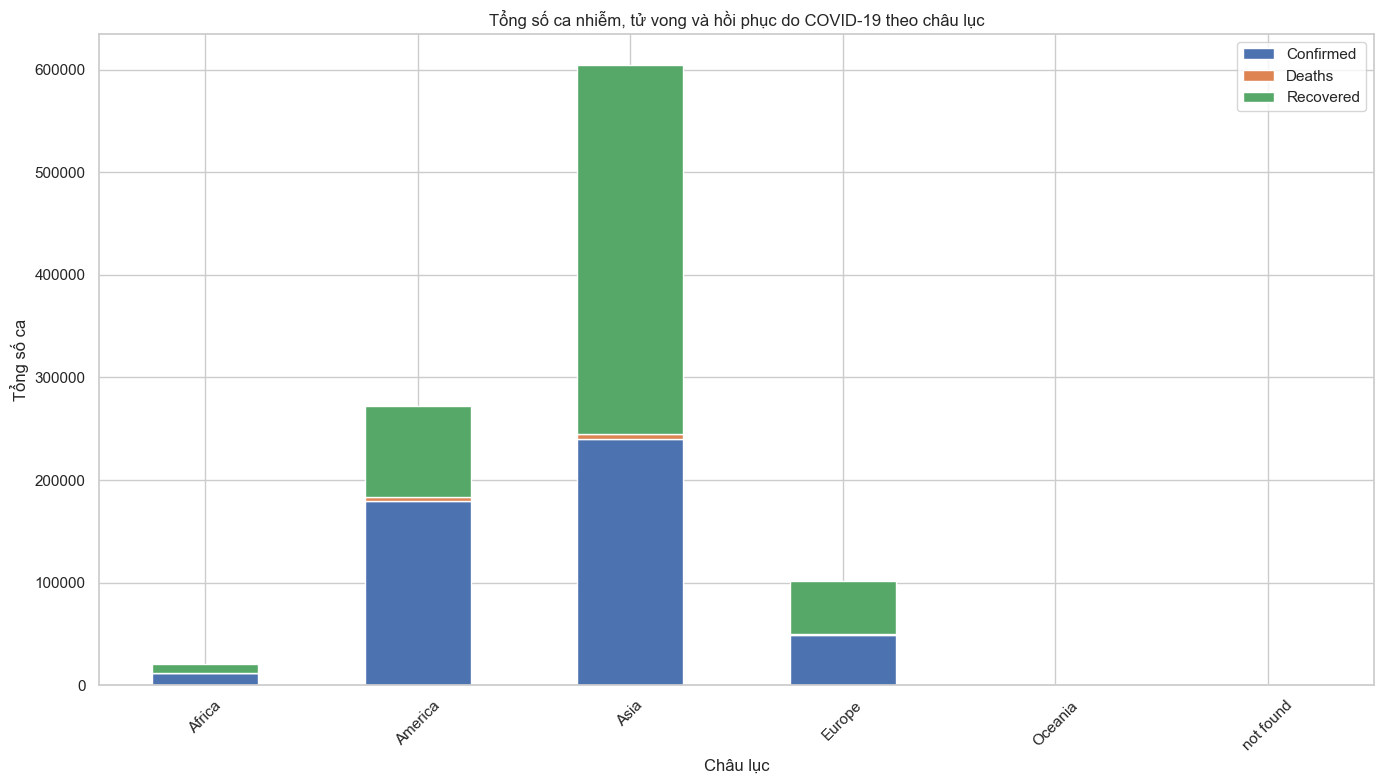

In [62]:
continent_data = df_latest_grouped.groupby('Continent')[['Confirmed', 'Deaths', 'Recovered']].sum()

# Vẽ stacked bar chart
continent_data.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Tổng số ca nhiễm, tử vong và hồi phục do COVID-19 theo châu lục')
plt.xlabel('Châu lục')
plt.ylabel('Tổng số ca')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Tỷ lệ tử vong và hồi phục theo châu lục

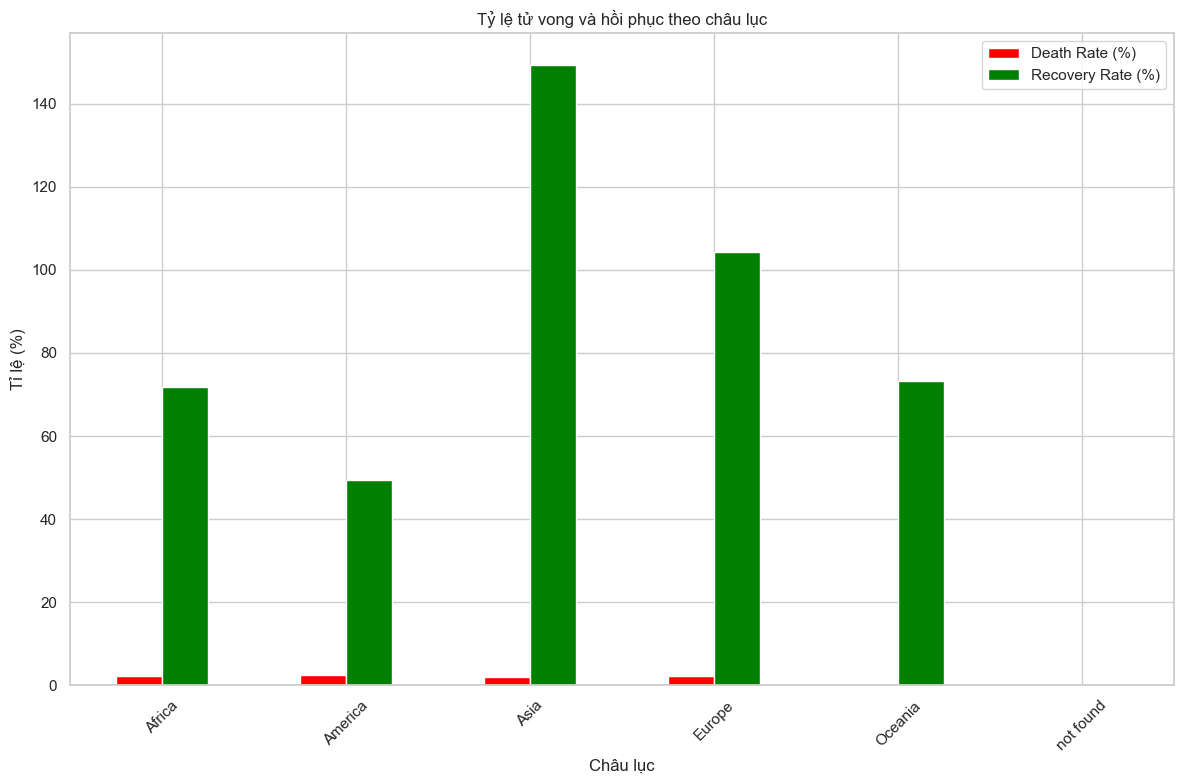

In [64]:
continent_data['Death Rate (%)'] = (continent_data['Deaths'] / continent_data['Confirmed']) * 100
continent_data['Recovery Rate (%)'] = (continent_data['Recovered'] / continent_data['Confirmed']) * 100

continent_data[['Death Rate (%)', 'Recovery Rate (%)']].plot(
    kind='bar', figsize=(12, 8), color=['red', 'green']
)
plt.title('Tỷ lệ tử vong và hồi phục theo châu lục')
plt.xlabel('Châu lục')
plt.ylabel('Tỉ lệ (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Phân phối tổng số ca bệnh theo châu lục

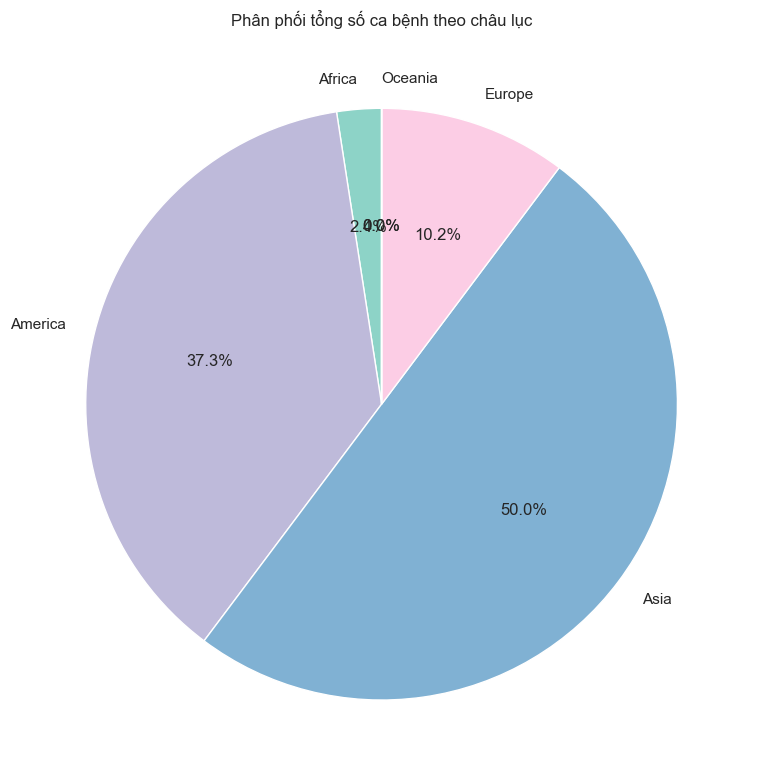

In [65]:
continent_cases = df_latest_grouped.groupby('Continent')['Confirmed'].sum()
plt.figure(figsize=(8, 8))
continent_cases.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Phân phối tổng số ca bệnh theo châu lục')
plt.ylabel('')
plt.tight_layout()
plt.show()


### Phân phối ca đang nhiễm (Active) theo châu lục

Các châu lục có giá trị âm:
Continent
Asia     -123404.0
Europe     -3248.0
Name: Active, dtype: float64


ValueError: pie plot doesn't allow negative values

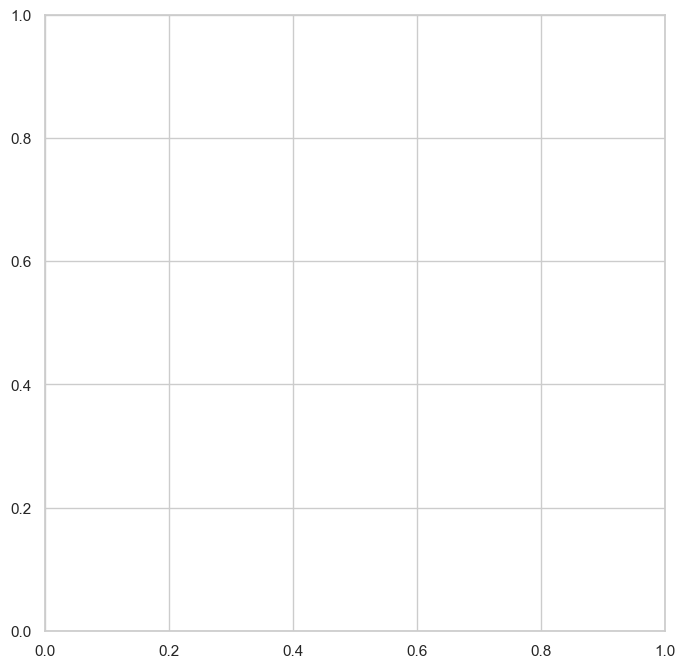

In [68]:
continent_active_cases = df_latest_grouped.groupby('Continent')['Active'].sum()

# In các châu lục có số Active < 0
print("Các châu lục có giá trị âm:")
print(continent_active_cases[continent_active_cases < 0])




plt.figure(figsize=(8, 8))
continent_active_cases.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='YlGnBu')
plt.title('Phân phối ca đang nhiễm (Active) theo châu lục')
plt.ylabel('')
plt.tight_layout()
plt.show()


Tỷ lệ hồi phục, tử vong, đang nhiễm toàn cầu

ValueError: Wedge sizes 'x' must be non negative values

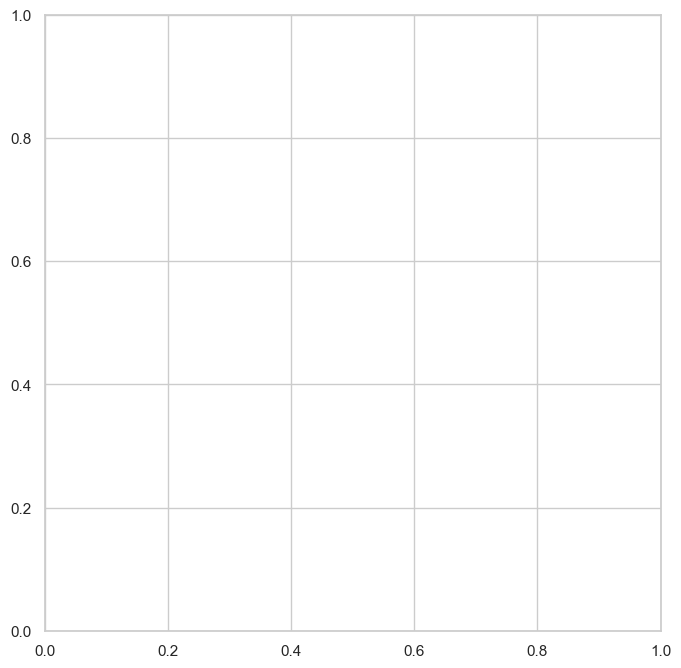

In [77]:
recovered_cases = df_latest_grouped['Recovered'].sum()
active_cases = df_latest_grouped['Active'].sum()
death_cases = df_latest_grouped['Deaths'].sum()

plt.figure(figsize=(8, 8))
plt.pie(
    [recovered_cases, active_cases, death_cases],
    labels=['Recovered', 'Active', 'Deaths'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#28a745', '#17a2b8', '#dc3545']
)
plt.title('Recovered, Active, and Death Cases Worldwide')
plt.tight_layout()
plt.show()


## Vẽ số ca bệnh của các nước lên bản đồ thế giới

In [85]:
import plotly.express as px


# Chuẩn bị dữ liệu: df_latest_grouped đã có cột 'Country/Region' và 'Confirmed'
# Nếu chưa có thì dùng đoạn xử lý ở trên để tạo

fig = px.scatter_geo(
    df_latest_grouped,
    locations="Country/Region",
    locationmode="country names",
    size="Confirmed",
    color_discrete_sequence=["red"],
    hover_name="Country/Region",
    hover_data={"Confirmed": True},
    projection="natural earth",
    title="Global COVID-19 Infections by Country (Bubble Map)",
    size_max=50  # bạn có thể chỉnh max size của chấm
)

fig.update_layout(
    geo=dict(showland=True, landcolor="lightgray"),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()
